In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import time
import torch
import spacy
from sklearn.model_selection import train_test_split



In [2]:
with open("SmallSimpleCorpus.txt") as file:
    small_corpora = file.readline()

In [3]:
# get rid of final period + newline which is interpreted differently for some strange reason
small_corpora=small_corpora[:-1] + " \n"  

small_corpora

'I hold a dog.  I hold the dog.  I hold a cat.  I hold the cat.  I rub a dog.  I rub the dog.  I rub a cat.  I rub the cat.  I hold and rub a dog.  I hold and rub the dog.  I hold and rub a cat.  I hold and rub the cat.  I hold a dog and cat.  I hold the dog and cat.  I hold a cat and dog.  I hold the cat and dog.  I rub a dog and cat.  I rub the dog and cat.  I rub a cat and dog.  I rub the cat and dog.  I hold and rub a dog .  I hold and rub a cat.  I hold and rub the dog.  I hold and rub the cat .  I can hold a dog.  I can hold the dog.  I can hold a cat.  I can hold the cat.  I can rub a dog.  I can rub the dog.  I can rub a cat.  I can rub the cat.  I can hold a dog and cat.  I can hold the dog and cat.  I can hold a cat and dog.  I can hold the cat and dog.  I can hold and rub a dog.  I can hold and rub the dog.  I can hold and rub a cat.  I can hold and rub the cat.  I can rub a dog and cat.  I can rub the dog and cat.  I can rub a cat and dog.  I can rub the cat and dog.  I can

In [4]:
# prepare text using the spacy english pipeline (see https://spacy.io/models/en)
# we'll use it to lemmatize the text, and determine which part of speech each
# lemmatize edits words to become the 'root' word - e.g. holds -> hold;  rubs->rub
# part of speech indicates if the item is a verb, nooun, punctuation, space and so on.
# make sure that the text sent to spacy doesn't end with a period immediately followed by a newline,
# instead, make sure there is a space between the period and the newline, so that the last period 
# is correctly identified as punctuation.

def prepare_texts(text):    
    # Get a callable object from spaCy that processes the text - lemmatizes and determines part of speech

    nlp = spacy.load("en_core_web_sm")
    
    # lemmatize the text, get part of speech, and remove spaces and punctuation
    
    lemmas = [tok.lemma_ for tok in nlp(text) if tok.pos_ not in ["PUNCT", "SPACE"]]
    
    # count the number of occurences of each word in the vocabulary
    
    freqs = Counter()  # word -> occurrence
    for w in lemmas:
        freqs[w] += 1
        
    vocab = list(freqs.items())  # List of (word, occurrence)
    
    vocab = sorted(vocab, key=lambda item: item[1], reverse=True)  # Sort by decreasing frequency
    print(vocab)
    
    # create word->index dictionary and index->word dictionary
    v2i = {v[0]:i for i,v in enumerate(vocab)}
    i2v = {i:v[0] for i,v in enumerate(vocab)}
    
    return lemmas, v2i, i2v

In [6]:
lemmas, v2i, i2v = prepare_texts(small_corpora)
print("small_corpora number of lemmatized words:", len(lemmas))
print("small_corpora Vocabulary size:", len(list(set(lemmas))))

[('and', 160), ('hold', 128), ('dog', 128), ('cat', 128), ('rub', 128), ('a', 104), ('the', 104), ('can', 104), ('she', 96), ('he', 96), ('I', 80)]
small_corpora number of lemmatized words: 1256
small_corpora Vocabulary size: 11


#### This following function walks through each word, and looks at a window (of size 'window') of words and creates input/output prediction pairs, predicting each of the words surrounding the current word from the current word.  So here we say that we are 'predicting the context' from the word

In [7]:
def tokenize_and_preprocess_text(textlist, v2i, window):

    # Predict context with word. Sample the context within a window size.

    X, Y = [], []  # is the list of training/test samples
    tokenized = [v2i[w] for w in textlist]
    
    for i, t in enumerate(tokenized):  # loop through each WORD
        for j in range(max(0, i-window//2), min(len(textlist), i+window//2)):
            if j == i: continue  # i.e. don't predict the WORD itself
            X.append(t)
            Y.append(tokenized[j])
    return X, Y

## Define Model that will be trained to produce word vectors

In [8]:
class Word2vecModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        # initialize word vectors to random number; 
        self.embedding = torch.nn.Parameter(torch.rand(vocab_size, embedding_size)) # * 0.01)
        
        # prediction function takes embedding as input, and predicts which word in vocabulary as output
        self.predictor = torch.nn.Linear(embedding_size, vocab_size)
        
    def forward(self, x):
        """
        x: torch.tensor of shape (L), L number of words input in a batch
        """
        e = self.embedding[x]  # (L, embedding_size)
        logits = self.predictor(e)  # (L, vocab_size)
        return logits, e

### The training function - give it the lemmatized text and it does the rest

In [9]:
def train_word2vec(textlist, window, embedding_size):
    # Set up a model with Skip-gram (predict context with word)
    # textlist: a list of the strings

    vocab_size = len(v2i)
    
    # Create the training data
    
    X, Y = tokenize_and_preprocess_text(textlist, v2i, window)
    
    # Split the training data
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    # instantiate the network & set up the optimizer
    
    network = Word2vecModel(vocab_size, embedding_size)
    optim = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    bsz = 4  # batch size
    num_epochs = 50
    start_time = time.time()
    
    # training loop
    
    for epoch in range(num_epochs):
        train_losses = []
        for i in range(0, len(X_train)-bsz, bsz):
            X_batch = torch.tensor(X_train[i: i+bsz])
            Y_batch = torch.tensor(Y_train[i: i+bsz])
            logits, _ = network.forward(X_batch)
            loss = torch.nn.CrossEntropyLoss()(logits, Y_batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
            train_losses.append(loss.item())
        
        # Eval the embedding
        if epoch % 10 == 9:
            X_batch = torch.tensor(X_test)
            Y_batch = torch.tensor(Y_test)
            with torch.no_grad():
                logits, _ = network.forward(X_batch)
                test_loss = torch.nn.CrossEntropyLoss()(logits, Y_batch).item()
            avg_train_loss = np.mean(train_losses)
            
            perplexity = np.exp(test_loss)  # Just an approximate. Should use test loss
            print("Epoch {: <3}, avg train loss {:.4f}, val loss {:.4f}, perplexity {:.4f}".format(
                epoch+1, avg_train_loss, test_loss, perplexity))

    print ("Done in {:.2f} seconds".format(time.time() - start_time))
    return network

### Run Training and retrieve embedding

In [10]:
window = 5
embedding_size = 2

np.random.seed(43)
torch.manual_seed(43)

network = train_word2vec(lemmas,window,embedding_size)
embedding = network.embedding

Epoch 10 , avg train loss 2.3170, val loss 2.3234, perplexity 10.2099
Epoch 20 , avg train loss 2.2572, val loss 2.2731, perplexity 9.7098
Epoch 30 , avg train loss 2.2467, val loss 2.2644, perplexity 9.6253
Epoch 40 , avg train loss 2.2419, val loss 2.2612, perplexity 9.5948
Epoch 50 , avg train loss 2.2388, val loss 2.2600, perplexity 9.5831
Done in 244.55 seconds


### Display 2-dimensional embedding on a 2-D Plot - points and words

Visualizing the 0 to 11 most frequent words


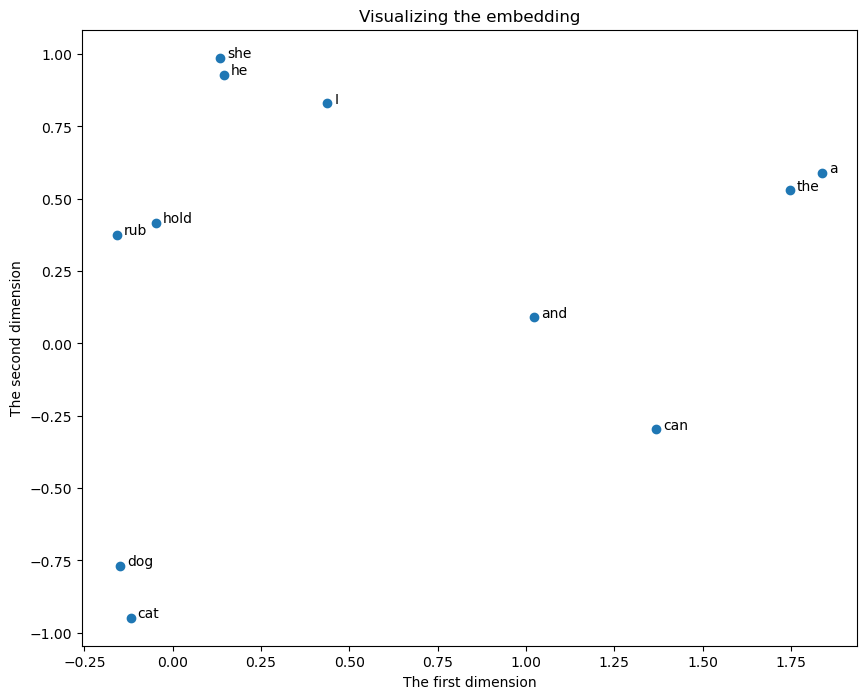

In [10]:
def visualize_embedding(embedding, most_frequent_from=0, most_frequent_to=40):
    assert embedding.shape[1] == 2, "This only supports visualizing 2-d embeddings!"
    print ("Visualizing the {} to {} most frequent words".format(most_frequent_from, most_frequent_to))
    fig = plt.figure(figsize=(10,8))
    ax = fig.gca()
    x, y = embedding[most_frequent_from:most_frequent_to,0], embedding[most_frequent_from:most_frequent_to,1]
    plt.scatter(x, y)

    for i in range(len(x)):
        ax.annotate(i2v[i], (x[i]+0.02, y[i]))
        
    plt.xlabel("The first dimension")
    plt.ylabel("The second dimension")
    plt.title("Visualizing the embedding")
    plt.show()
    
visualize_embedding(embedding.detach().numpy(), most_frequent_from=0, most_frequent_to=11)    

### Find nearest neighbors


In [11]:
def nearest_neighbors(embedding, textlist, topn=3, most_frequent_from=0, most_frequent_to=20):
    for i, w in enumerate(v2i):
        if i >= most_frequent_from:
            vec = embedding[i]
            sims = [(j,torch.nn.functional.cosine_similarity(vec, x, dim=0).item()) for j,x in enumerate(embedding) if j != i]
            sorted_sims = sorted(sims, key=lambda item: item[1], reverse=True)
            nearest_neighbor_ids = [item[0] for item in sorted_sims[:topn]]
            nearest_neighbor_words = [i2v[i] for i in nearest_neighbor_ids]
            print("Nearest neighbors for {: <10} {}".format(w, ",".join(nearest_neighbor_words)))
        if i == most_frequent_to:
            break
        
nearest_neighbors(network.embedding.data, lemmas, topn=1, most_frequent_from=0, most_frequent_to=20)




Nearest neighbors for and        the
Nearest neighbors for hold       she
Nearest neighbors for dog        cat
Nearest neighbors for cat        dog
Nearest neighbors for rub        hold
Nearest neighbors for a          the
Nearest neighbors for the        a
Nearest neighbors for can        and
Nearest neighbors for she        he
Nearest neighbors for he         she
Nearest neighbors for I          he
